In [1]:
import pandas as pd
import numpy as np 
from datetime import datetime
import argparse
import csv
import os
import time 
import sqlalchemy
import urllib
import json
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Create a pyodbc connection
CONFIG_LOCATION = 'config-sample.json'

def get_config():
    with open(CONFIG_LOCATION, 'r') as f:
        return json.load(f)
    
def build_sql_engine():
    config = get_config()
    params = urllib.parse.quote_plus("DRIVER={" + config['dbdriver'] + "};"
                                 "SERVER=" + config['dbserver'] +
                                 ";DATABASE=" + config['dbdatabase'] +
                                 ";Trusted_Connection=yes;")
    engine = sqlalchemy.create_engine("mssql+pyodbc:///?odbc_connect={}".format(params))
    return engine 

In [3]:
table_name = "tmp_data_combined_3"
sql_engine = build_sql_engine()
table_df = pd.read_sql_table(
    table_name,
    con=sql_engine
)

In [4]:
feature_list = ['NumAssignmentSubmissions','NumQuizDone','NumPosts','NumTopics','NumChatSessions']
table_df[feature_list].describe()

,NumAssignmentSubmissions,NumQuizDone,NumPosts,NumTopics,NumChatSessions
count,306.000000,306.000000,306.000000,306.000000,306.0
mean,6.078431,2.718954,9.303922,3.617647,0.0
std,5.866861,4.315367,8.993027,3.095351,0.0
min,0.000000,0.000000,0.000000,0.000000,0.0
25%,1.000000,0.000000,2.000000,1.000000,0.0
50%,5.000000,1.000000,7.000000,3.000000,0.0
75%,9.000000,4.000000,14.000000,5.000000,0.0
max,35.000000,30.000000,50.000000,14.000000,0.0


In [7]:
# add a zero row for baseline for all courses 
# Adding dummy records to force-fit 0 into the feature columns 
table_df = pd.concat([table_df,
    pd.DataFrame({
    'UserId' : '9999999999',
    'OrgUnitId' : pd.unique(table_df.OrgUnitId),
    'Organization' : 'NA',
    'Type' : 'NA',
    'CourseName' : 'NA',
    'EnrollmentDate' : max(table_df.EnrollmentDate),
    'NumAssignmentSubmissions' : 0,
    'NumQuizDone' : 0,
    'NumPosts' : 0,
    'NumTopics' : 0 })]
    )

In [8]:
table_df['NumAssignmentSubmissions_pct'] = table_df.\
                                           groupby('OrgUnitId')['NumAssignmentSubmissions'].\
                                           rank(pct=True,method='max')

table_df['NumQuizDone_pct'] = table_df.\
                              groupby('OrgUnitId')['NumQuizDone'].\
                              rank(pct=True,method='max')

table_df['NumPosts_pct'] = table_df.\
                              groupby('OrgUnitId')['NumPosts'].\
                              rank(pct=True,method='max')

table_df['NumTopics_pct'] = table_df.\
                              groupby('OrgUnitId')['NumTopics'].\
                              rank(pct=True,method='max')

table_df['NumChatSessions_pct'] = table_df.\
                              groupby('OrgUnitId')['NumChatSessions'].\
                              rank(pct=True,method='max')

In [9]:
# table_df.head()
# pd.unique(table_df.OrgUnitId)
# table_df[table_df.OrgUnitId == 1822226][['UserId','NumAssignmentSubmissions','NumAssignmentSubmissions_pct']]

In [10]:
table_df['EngagementIndex'] =  (table_df['NumAssignmentSubmissions_pct'] +
                              table_df['NumQuizDone_pct'] + 
                              table_df['NumPosts_pct'] + 
                              table_df['NumTopics_pct'] + 
                              table_df['NumChatSessions_pct']) / 5.0 * 100.00

In [11]:
table_df = table_df[table_df.UserId != '9999999999']
# datetime formatting
table_df['EnrollmentDate'] = table_df.EnrollmentDate.dt.date

In [12]:
table_df.loc[:,'CourseTerm'] = table_df.loc[:,'CourseName'].\
                         apply(lambda x : ' '.join(word for word in x.split(' ')[-3:-1]))

table_df.loc[:,'CourseTitle'] = table_df.loc[:,'CourseName'].\
                                 apply(lambda x : ' '.join(word for word in x.split(' ')[:-5]))

table_df.loc[:,'CourseSection'] = table_df.loc[:,'CourseName'].\
    apply(lambda x : ' '.join(word for word in x.split(' ')[-5:-3]))

In [13]:
# table_df.to_csv("EngagementIndexResult.csv")
table_df[['UserId','OrgUnitId','Organization','Type','EnrollmentDate',
                    'EngagementIndex','CourseTerm','CourseTitle','CourseSection']].\
                     to_excel("EngagementIndexResult.xlsx")

#### PLots

<Figure size 864x432 with 0 Axes>

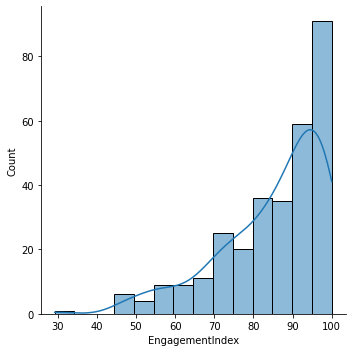

In [216]:
plt.figure(figsize=(12,6))
sns_plot = sns.displot(table_df['EngagementIndex'],kde=True)
sns_plot.savefig("distplot.png")

In [157]:
# !pip install seaborn

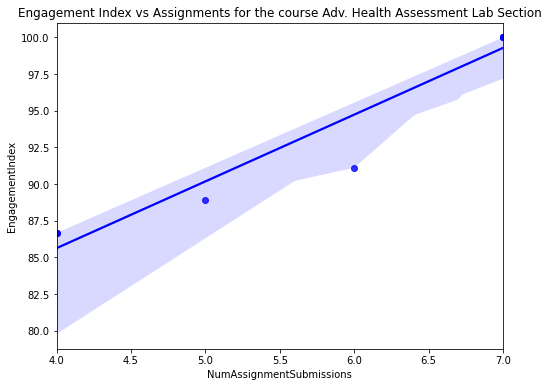

In [203]:
reg_data = table_df[table_df.OrgUnitId  == 1822955]
plt.figure(figsize=(8,6))
plt.title("Engagement Index vs Assignments for the course Adv. Health Assessment Lab Section", size=12)
poi = sns.regplot(x=reg_data['NumAssignmentSubmissions'], y=reg_data['EngagementIndex'], color="blue")
poi.figure.savefig("regplot_1.png")

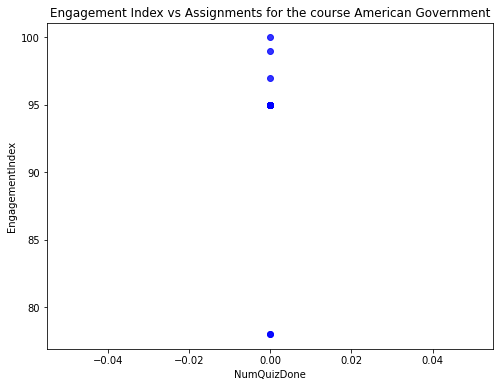

In [19]:
reg_data = table_df[table_df.OrgUnitId  == 1838198]
plt.figure(figsize=(8,6))
plt.title("Engagement Index vs Assignments for the course American Government", size=12)
poi = sns.regplot(x=reg_data['NumQuizDone'], y=reg_data['EngagementIndex'], color="blue")
poi.figure.savefig("regplot_2.png")

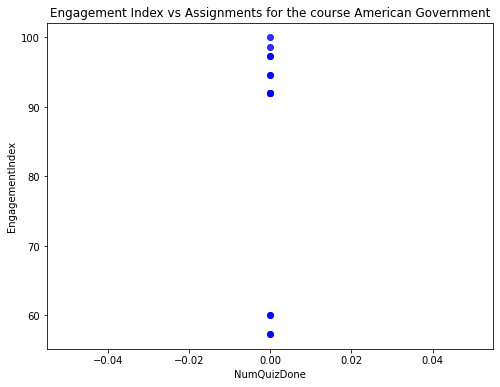

In [18]:
reg_data = table_df[table_df.OrgUnitId  == 1925630]
plt.figure(figsize=(8,6))
plt.title("Engagement Index vs Assignments for the course American Government", size=12)
poi = sns.regplot(x=reg_data['NumQuizDone'], y=reg_data['EngagementIndex'], color="blue")
#poi.figure.savefig("regplot_2.png")

In [5]:
pd.unique(table_df.OrgUnitId)

array([1823952, 1822959, 1822503, 1822028, 1822286, 1822606, 1838174,
       1838202, 1822226, 1823962, 1822504, 1822817, 1822250, 1925630,
       1822955, 1924206, 1838194, 1943335, 1820877, 1925631, 1918793,
       1838198, 1932065, 1822495, 1822487, 1844617, 1823741, 1821825,
       1824996, 1868083], dtype=int64)

In [36]:
corr = table_df[['NumAssignmentSubmissions',
         'NumQuizDone',
          'NumPosts',
          'NumTopics',
          'NumChatSessions',
          'EngagementIndex']].corr()
corr = corr.fillna(0)
corr.style.background_gradient(cmap='coolwarm')
# plt.figure(figsize=(12,10))
# corr.title("Engagement Index vs Assignments for the course American Government", size=12)
corr.savefig('corr.png', bbox_inches='tight', pad_inches=0.0)

AttributeError: 'DataFrame' object has no attribute 'savefig'